# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews order by time
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [3]:
final.shape
final['Score'].size

364171

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
print(final.shape)

(364171, 12)


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [5]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [6]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'at', "you're", 'don', 'o', 'she', 'with', 'during', 'yourself', 'why', 'up', 'so', 'ourselves', 'been', 'were', "needn't", 'nor', 'very', 'again', 'through', "weren't", 't', 'hers', 'their', 'your', 'herself', 'they', 'not', 'other', 'where', 'or', 'am', 'her', 'those', 'you', "couldn't", 'ours', 'as', 'into', 'mustn', 'only', 'each', 'a', "you've", 'have', 'by', 'mightn', 'under', 'm', 'y', "isn't", 'll', 'doing', 'his', 'd', 'than', 'haven', "that'll", 'few', 'when', 're', 'before', 'for', 'about', 'being', 'couldn', 'some', 'our', 'them', 'what', "shouldn't", 'doesn', 'then', 'which', 'do', 'in', 'my', 'between', 'did', "mightn't", 'won', 'these', 'once', 'from', 'yourselves', 'shouldn', 'over', 'are', "she's", 'no', 'does', 'after', 'too', 'off', 'can', 'myself', 'that', 'himself', 'of', "didn't", 'such', "hadn't", 'same', 'and', 'me', 'further', 'down', 'there', 'the', 'hadn', 've', "you'll", 'having', "shan't", 'wasn', 'now', "aren't", 'didn', 'but', 'to', 'had', "hasn't", 'isn

In [7]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [8]:
%%time
# Code takes a while to run as it needs to run on around 500k sentences.
i=0
str1=' '
final_string_nostem=[]
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)# remove HTMl tags
    sent=cleanpunc(sent)# remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=w.lower().encode('utf8') #encoding as byte-string/utf-8
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence)     
    final_string_nostem.append(str1)
    i+=1
print("Preprocessing completed in ")

Preprocessing completed in 
Wall time: 54 s


In [9]:
final=final[:20000]

In [10]:
final.shape

(20000, 12)

In [11]:
###Sorting as we want according to time series
final.sort_values('Time',inplace=True) 
final.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
5,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
6,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
7,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
8,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
9,346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,get crazi look beatlejuic french version video...


In [12]:
savetofile(final,"sample_25000_knn")

In [13]:
final = openfromfile("sample_25000_knn")

In [14]:
final['Score'].value_counts()

positive    17826
negative     2174
Name: Score, dtype: int64

In [15]:
final.shape

(20000, 12)

# [7.2.2] Bag of Words (BoW)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer(min_df = 10) 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000, 3479)
Test Data Size:  (6000, 3479)


In [36]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(1280, 3479) (1272, 3479)
(2552, 3479) (1272, 3479)
(3824, 3479) (1272, 3479)
(5096, 3479) (1272, 3479)
(6368, 3479) (1272, 3479)
(7640, 3479) (1272, 3479)
(8912, 3479) (1272, 3479)
(10184, 3479) (1272, 3479)
(11456, 3479) (1272, 3479)
(12728, 3479) (1272, 3479)


# brute force

In [37]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
# neigh = np.arange(1,30,2)
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 14.8min finished


Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 89.10%


Accuracy on test set: 89.550%
Precision on test set: 0.897
Recall on test set: 0.998
F1-Score on test set: 0.852
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



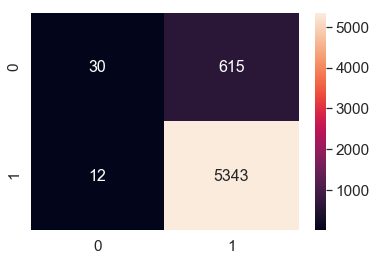

In [38]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## KNN with Kd-tree Algorithm

In [39]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train)
X_test_vec_dense = svd.transform(X_test)


knn = KNeighborsClassifier(algorithm='kd_tree')
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train_vec_dense,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 49.4min finished


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 88.88%


Accuracy on test set: 89.433%
Precision on test set: 0.898
Recall on test set: 0.995
F1-Score on test set: 0.854
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



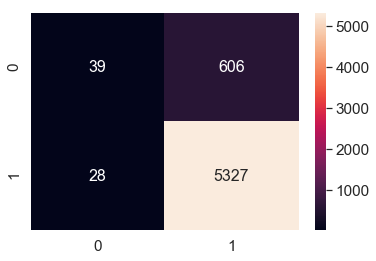

In [40]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=29,algorithm='kd_tree')
knn.fit(X_train_vec_dense,y_train)
y_pred = knn.predict(X_test_vec_dense)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [7.2.5] TF-IDF

In [51]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final['CleanedText'].values,final['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(min_df=10) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000, 3479)
Test Data Size:  (6000, 3479)
Wall time: 2.83 s


In [42]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(1280, 3479) (1272, 3479)
(2552, 3479) (1272, 3479)
(3824, 3479) (1272, 3479)
(5096, 3479) (1272, 3479)
(6368, 3479) (1272, 3479)
(7640, 3479) (1272, 3479)
(8912, 3479) (1272, 3479)
(10184, 3479) (1272, 3479)
(11456, 3479) (1272, 3479)
(12728, 3479) (1272, 3479)


# brute force

In [43]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

knn = KNeighborsClassifier(algorithm='brute',n_jobs=2)
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 24.7min finished


Best HyperParameter:  {'n_neighbors': 7}
Best Accuracy: 89.28%


Accuracy on test set: 89.833%
Precision on test set: 0.901
Recall on test set: 0.996
F1-Score on test set: 0.861
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



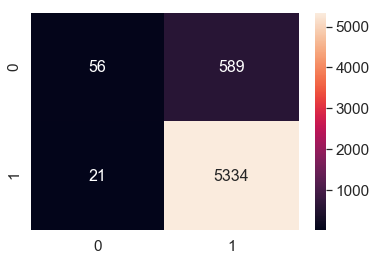

In [44]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## kd_tree implementation)

In [45]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train)
X_test_vec_dense = svd.transform(X_test)



In [46]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

Wall time: 0 ns


In [47]:
knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=2)
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train_vec_dense,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 25.8min finished


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 88.88%


Accuracy on test set: 89.317%
Precision on test set: 0.900
Recall on test set: 0.990
F1-Score on test set: 0.858
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



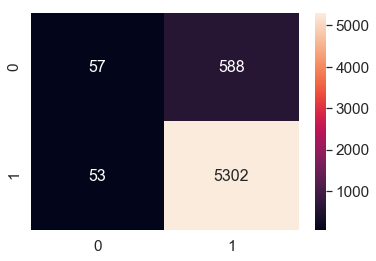

In [48]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=29,algorithm='kd_tree')
knn.fit(X_train_vec_dense,y_train)
y_pred = knn.predict(X_test_vec_dense)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [7.2.6] Word2Vec

In [16]:
import gensim
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [17]:
import gensim
model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50,workers=4)  
#model = KeyedVectors.load_word2vec_format('amazon-fine-food-reviews/GoogleNews-vectors-negative300.bin', binary=True)
print(type(model))
#model_train=gensim.models.Word2Vec(final_train['CleanedText'].tolist(),min_count=5,size=50, workers=4)  
#print(type(model_train)

<class 'gensim.models.word2vec.Word2Vec'>


In [18]:
words = list(model.wv.vocab)
print(len(words))
print(model)

6304
Word2Vec(vocab=6304, size=50, alpha=0.025)


In [20]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

20000
50


In [21]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(sent_vectors)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,final['Score'].values,test_size=0.3,shuffle=False)

In [22]:
avg_vec_norm.shape

(20000, 50)

In [23]:
avg_vec_norm.max()

0.5498272102806953

In [24]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Brute force

In [25]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute',n_jobs=2)
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))}#params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 29.8min finished


Best HyperParameter:  {'n_neighbors': 11}
Best Accuracy: 89.38%


Accuracy on test set: 89.600%
Precision on test set: 0.905
Recall on test set: 0.987
F1-Score on test set: 0.866
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



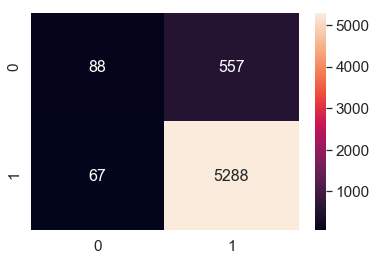

In [28]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Kd tree Algorithm

In [32]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=40)
X_train_vec_dense = svd.fit_transform(X_train)
X_test_vec_dense = svd.transform(X_test)

knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=2)
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train_vec_dense,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  9.1min finished


Best HyperParameter:  {'n_neighbors': 13}
Best Accuracy: 89.34%


Accuracy on test set: 89.500%
Precision on test set: 0.903
Recall on test set: 0.988
F1-Score on test set: 0.864
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



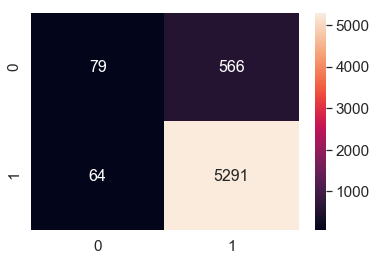

In [34]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=13,algorithm='kd_tree')
knn.fit(X_train_vec_dense,y_train)
y_pred = knn.predict(X_test_vec_dense)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [7.2.7] Avg W2V, TFIDF-W2V

In [16]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [18]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [19]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6304
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas']


In [22]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:48<00:00, 415.28it/s]


20000
50


In [23]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [24]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [00:51<00:00, 390.88it/s]


In [25]:
tfidf_w2v_vec = np.array(tfidf_sent_vectors)

In [26]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,final['Score'].values,test_size=0.3,shuffle=False)

Brute Algorithm

In [27]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

knn = KNeighborsClassifier(algorithm='brute',n_jobs=2)
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 37.4min finished


Best HyperParameter:  {'n_neighbors': 9}
Best Accuracy: 89.06%


Accuracy on test set: 88.983%
Precision on test set: 0.904
Recall on test set: 0.981
F1-Score on test set: 0.861
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



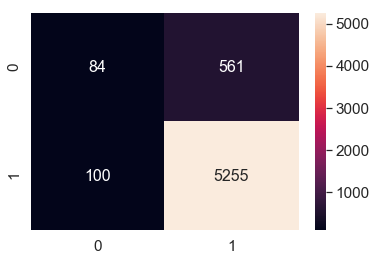

In [28]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Kd tree Algorithm

In [33]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD
X_train_vec_dense = svd.fit_transform(X_train)
X_test_vec_dense = svd.transform(X_test)

knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=2)
myList = list(range(0,30))
param_grid = {'n_neighbors':list(filter(lambda x: x % 2 != 0, myList))} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train_vec_dense,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 12.1min finished


Best HyperParameter:  {'n_neighbors': 13}
Best Accuracy: 89.07%


Accuracy on test set: 89.333%
Precision on test set: 0.903
Recall on test set: 0.987
F1-Score on test set: 0.862
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



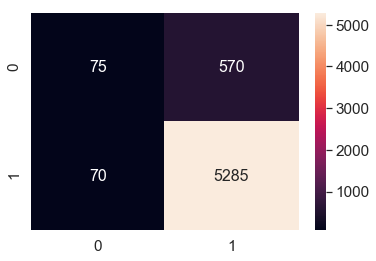

In [35]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_vec_dense,y_train)
y_pred = knn.predict(X_test_vec_dense)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,pos_label='positive')))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,pos_label='positive')))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,pos_label='positive',average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [14]:
# Creating table using PrettyTable library
from prettytable import PrettyTable
# Names of models
featurization = ['Bag of Words brute force','Bag of Words kd tree','Tf-Idf brute force',\
                'Tf-Idf kd tree','Avg word 2 vec brute force','Avg word 2 vec kd tree',\
                'TFIDF weighted w2vec brute force','TFIDF weighted w2vec kd tree']
# Training accuracies
accuracy = [89.10,88.88,89.28,88.88,89.38,89.34,89.06,89.07]
F1score = [0.852,0.854,0.861,0.858,0.866,0.864,0.861,0.862]
numbering = [1,2,3,4,5,6,7,8]
# Initializing prettytable
ptable = PrettyTable()
# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",featurization)
ptable.add_column("accuracy",accuracy)
ptable.add_column("F1 score",F1score)
# Printing the Table
print(ptable)

+-------+----------------------------------+----------+----------+
| S.NO. |              MODEL               | accuracy | F1 score |
+-------+----------------------------------+----------+----------+
|   1   |     Bag of Words brute force     |   89.1   |  0.852   |
|   2   |       Bag of Words kd tree       |  88.88   |  0.854   |
|   3   |        Tf-Idf brute force        |  89.28   |  0.861   |
|   4   |          Tf-Idf kd tree          |  88.88   |  0.858   |
|   5   |    Avg word 2 vec brute force    |  89.38   |  0.866   |
|   6   |      Avg word 2 vec kd tree      |  89.34   |  0.864   |
|   7   | TFIDF weighted w2vec brute force |  89.06   |  0.861   |
|   8   |   TFIDF weighted w2vec kd tree   |  89.07   |  0.862   |
+-------+----------------------------------+----------+----------+
